In [ ]:
IS_COLAB = False
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  DATASET = '/content/drive/My Drive/catsdogs/PetImages'
else:
  DATASET = r'c:\Users\Gruzilkin\Downloads\PetImages'

In [ ]:
import os, sys, random, math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

from PIL import Image 
from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# What are neural nets?

high level APIs like Keras makes it looks like a black box, so you expect that inside it's something like this

![alt text](https://www.dropbox.com/s/zvh7faxaqc6me1s/ai_marketing.png?dl=1)

# Reality

![alt text](https://www.dropbox.com/s/ltxuc3vxaxcdc10/ai_real.png?dl=1)

# What does it actually do?


 - matrix multiplications
 - non-linear functions

# Why is matrix multiplication useful here?
matrix may contain data in the form of an array of n-dimentional vectors and by multiplying it by a transformation matrix we can map our vectors into a different space, even of different dimentionality

# What is transformation matrix?
it's a matrix that defines new basis vectors instead of standard basis vectors x[1,0] and y[0,1]

## transformation matrices allows us to do:
* Scaling
* Rotation
* Shearing
* Reflection

In [ ]:
def visualize_transformation(matrix):
    x = np.random.uniform(1,10, size=100)
    y = np.random.uniform(1,2, size=100)
    data = np.vstack([x,y]).T              # data.shape: (100, 2)

    transformed_data = data.dot(matrix.T)

    plt.scatter(data[:, 0], data[:, 1], marker='.', color='blue')
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], marker='.', color='red')
    plt.axes().set_aspect('equal')

# Example of rotation matrix

[[ 0.8660254 -0.5      ]
 [ 0.5        0.8660254]]


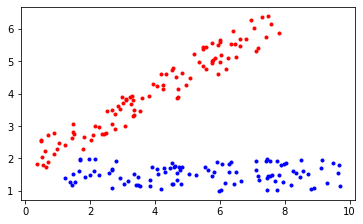

In [ ]:
def rotationMatrix(angle):
  angle = (math.pi / 180) * angle
  return np.array([[math.cos(angle), -math.sin(angle)],
                   [math.sin(angle), math.cos(angle)]])

angle = 30
matrix = rotationMatrix(angle)

print(matrix)

visualize_transformation(matrix)

# Example of scaling matrix

[[2 0]
 [0 2]]


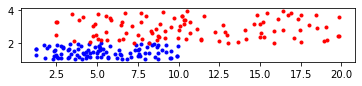

In [ ]:
def scaleMatrix(factor):
    return np.array( [[factor, 0],
                      [0, factor]])

factor = 2
matrix = scaleMatrix(factor)

print(matrix)

visualize_transformation(matrix)

# How can it be applied to problems?
Let's say we have lots of cats and dogs (2D data points) sitting in 2 groups

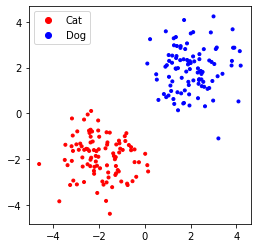

In [ ]:
x = np.random.standard_normal(100) + 2
y = np.random.standard_normal(100) + 2
data1 = np.vstack([x,y])
label1 = np.ones(100)

x = np.random.standard_normal(100) - 2
y = np.random.standard_normal(100) - 2
data2 = np.vstack([x,y])
label2 = np.zeros(100)

data = np.hstack([data1, data2]).T
labels = np.hstack([label1, label2])

scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, marker='.',
            cmap=matplotlib.colors.ListedColormap(['red', 'blue']))
plt.axes().set_aspect('equal')
plt.legend(handles=scatter.legend_elements()[0], labels=["Cat", "Dog"])
plt.show()

based on this data we want to create a function $f(x,y)$ that would return **0** for **<span style="color:red">cat</span>**, and **1** for **<span style="color:blue">dog</span>**

the function would take the following form:

$f(x,y)=sigmoid(w_1 x + w_2 y + B)$

or in the vector form:

$f(\vec{x})=sigmoid(W\times\vec{x} + B)$

# Good news
we don't have to calculate anything, pytorch is going to do it for us (or tensorflow)

In [ ]:
W = torch.randn((2, 1), dtype=torch.float32, requires_grad=True)
B = torch.randn((1, 1), dtype=torch.float32, requires_grad=True)

optimizer = torch.optim.Adam([W,B], lr=0.1, weight_decay=0.1)

data_tensor = torch.from_numpy(data).float()
labels_tensor = torch.from_numpy(labels).float()

for i in range(100):
    
  score = torch.sigmoid(torch.mm(data_tensor, W) + B)   # this is our f(x,y) function

  loss = torch.nn.functional.binary_cross_entropy(score, labels_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

this is our $f(x,y)$ in the form of a regular python function, it takes any $x,y$ and tells us if there's a cat or a dog

it has some code to convert between numpy arrays and pytorch tensors, and it uses **W** and **B** that were calculated for us by pytorch

In [ ]:
def predict(data):
  data_tensor = torch.from_numpy(data).float()
  score = torch.sigmoid(torch.mm(data_tensor, W) + B)
  return score.detach().numpy()

now we can visualize this function by calling it for every point on the grid

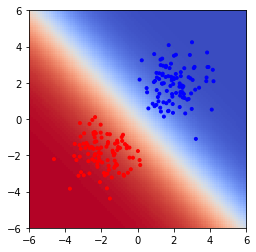

In [ ]:
xlist = np.linspace(-6.0, 6.0, 100)
ylist = np.linspace(-6.0, 6.0, 100)
X, Y = np.meshgrid(xlist, ylist)
mesh = np.dstack([X,Y]).reshape(-1, 2)     # mesh.shape: (100*100, 2)
z = predict(mesh).reshape(100,100)         # z.shape: (100, 100)

plt.imshow(z, cmap=plt.cm.coolwarm_r, origin='lower', extent=[X.min(), X.max(), Y.min(), Y.max()])
plt.scatter(data[:, 0], data[:, 1], c=labels, marker='.', cmap=matplotlib.colors.ListedColormap(['red', 'blue']))
plt.axes().set_aspect('equal')


# What about $W$ and $B$?

In [ ]:
print(f'W is a 2x1 matrix:\n {W}\n')
print(f'B is a 1x1 matrix: {B}')

W is a 2x1 matrix:
 tensor([[0.8477],
        [0.8142]], requires_grad=True)

B is a 1x1 matrix: tensor([[0.0028]], requires_grad=True)


$W$ is a $2\times1$ matrix which means it translates from **2D** space into **1D** space (projects onto a line)

we can apply only this transformation, without sigmoid, and see what happens

In [ ]:
data_1d = torch.mm(data_tensor, W) + B  # no sigmoid here
data_1d = data_1d.squeeze(1).detach().numpy()

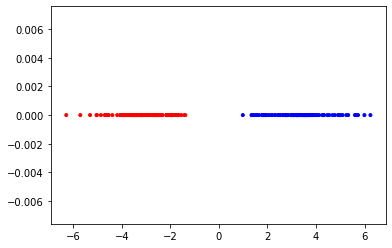

In [ ]:
plt.scatter(data_1d, np.zeros_like(data_1d), c=labels, marker='.', cmap=matplotlib.colors.ListedColormap(['red', 'blue']))
plt.show()

transformation defined by $W$ and $B$ puts our **<span style="color:red">cats</span>** and **<span style="color:blue">dogs</span>** on a line, on the opposite sides from **0**

and after we apply $sigmoid$ we get **0** for **<span style="color:red">cats</span>**, and **1** for **<span style="color:blue">dogs</span>**

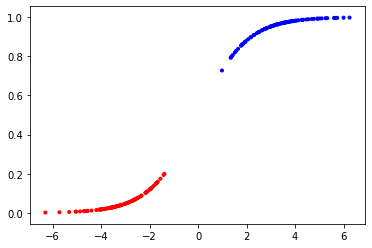

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

y = sigmoid(data_1d)

plt.scatter(data_1d, y, c=labels, marker='.', cmap=matplotlib.colors.ListedColormap(['red', 'blue']))
plt.show()

# What about neural networks?

neural networks consist of multiple layers which receive high dimentional vectors as inputs, perform transformation using their own weights matricies or non-linear functions like sigmoid, and pass results to the next layer

the following code defines a simple function that distinguishes cats and dogs on photos

In [ ]:
WEIGHTS_FILE = 'weights.pt'
DATASET_FILE = 'ds.pt'

WEIGHTS_PATH = os.path.join(DATASET, WEIGHTS_FILE)
DATASET_PATH = os.path.join(DATASET, DATASET_FILE)

In [ ]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

BATCH_SIZE = 256

print('using device:', device)

using device: cuda


In [ ]:
def load_tensor_dataset():
    if os.path.isfile(DATASET_PATH):
        return torch.load(DATASET_PATH)
    else:
        dataset = create_tensor_dataset()
        torch.save(dataset, DATASET_PATH)
        return dataset
    

def create_tensor_dataset():
    categories = ["Cat", "Dog"]
    tensors = []
    targets = []
    for target, category in enumerate(categories):
        directory = os.path.join(DATASET, category)
        for file in os.listdir(directory):
            if file.endswith(".jpg"):
                try:
                    filePath = os.path.join(directory, file)
                    image = Image.open(filePath)
                    tensor = transform(image)
                    tensors.append(tensor)
                    targets.append(target)
                except RuntimeError:
                    #print(f'error on {filePath}')
                    pass
    X = torch.stack(tensors)
    Y = torch.Tensor(targets).long()
    return torch.utils.data.TensorDataset(X, Y)

In [ ]:
transform = transforms.Compose([
            transforms.Resize((64,64)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

# Where is our neural net?

it's defined in **cat_or_dog** function with only 3 matrix multiplication

In [ ]:
w1, b1, w2, b2, w3, b3 = None, None, None, None, None, None

def cat_or_dog(x):
  x = x.flatten(start_dim=1)       # input photo is 3x64x64 and we need to reshape it

  x = torch.mm(x, w1) + b1         # w1 is 12288x1024 matrix
  x = x.clamp(min=0)
  x = torch.mm(x, w2) + b2         # w2 is 1024x1024 matrix
  x = x.clamp(min=0)
  x = torch.mm(x, w3) + b3         # w3 is 1024x2 matrix
    
  return x

this function basically transforms **12288**-dimentional vectors into **2**-dimentional vectors

In [ ]:
def check_accuracy(model, loader, singleBatch=False):
    num_correct = 0
    num_samples = 0
    batch_count = 0
    loss_accumulator = 0
    with torch.no_grad():
        for x, y in loader:
            batch_count += 1
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            
            loss = F.cross_entropy(scores, y)
            loss_accumulator += loss.item()
            
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            if singleBatch:
                break
        acc = float(num_correct) / num_samples
        loss = loss_accumulator / batch_count
        return (acc, loss)

In [ ]:
def storeWeights():
    torch.save((w1,b1,w2,b2,w3,b3), WEIGHTS_PATH)

In [ ]:
def loadWeights():
    return torch.load(WEIGHTS_PATH)

In [ ]:
def load_or_train_weights():
    if os.path.isfile(WEIGHTS_PATH):
        global w1, b1, w2, b2, w3, b3
        (w1,b1,w2,b2,w3,b3) = loadWeights()
    else:
        train()
        
def train():
    global w1, b1, w2, b2, w3, b3
    w1 = torch.randn((64*64*3, 1024), dtype=dtype, device=device, requires_grad=True)
    b1 = torch.randn((1, 1024), dtype=dtype, device=device, requires_grad=True)

    w2 = torch.randn((1024, 1024), dtype=dtype, device=device, requires_grad=True)
    b2 = torch.randn((1, 1024), dtype=dtype, device=device, requires_grad=True)

    w3 = torch.randn((1024, 2), dtype=dtype, device=device, requires_grad=True)
    b3 = torch.randn((1, 2), dtype=dtype, device=device, requires_grad=True)
    
    optimizer = torch.optim.Adam([w1,b1,w2,b2,w3,b3], weight_decay=0.1)

    memory_dataset = load_tensor_dataset()

    train_loader = torch.utils.data.DataLoader(memory_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8)
    
    for e in range(10):
      for x, y in train_loader:
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device)

        score = cat_or_dog(x)

        loss = F.cross_entropy(score, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
      (acc, loss) = check_accuracy(cat_or_dog, train_loader)
      print(f'Generation {e}:\taccuracy:{acc*100}\tloss:{loss}')
        
    storeWeights()
        
load_or_train_weights()

Generation 0:	accuracy:66.59179334964503	loss:7190.59056122449
Generation 1:	accuracy:73.35044723436685	loss:4316.988316127232
Generation 2:	accuracy:80.47009746901448	loss:2255.5911092952806
Generation 3:	accuracy:84.33676948377521	loss:1365.7324710768096
Generation 4:	accuracy:88.7770245878625	loss:773.0531535245934
Generation 5:	accuracy:87.55364806866953	loss:890.113567118742
Generation 6:	accuracy:92.1222574305082	loss:436.2948686249402
Generation 7:	accuracy:91.9939031727568	loss:466.00059446996573
Generation 8:	accuracy:93.14106935140988	loss:355.458106838927
Generation 9:	accuracy:95.2990253098552	loss:179.50394836737186


In [ ]:
def predict_cat_or_dog(img):
    tensor = transform(img).unsqueeze(0).to(device=device)
    score = cat_or_dog(tensor)
    _, pred = score.max(1)

    return score, ["Cat", "Dog"][pred.item()]

In [ ]:
def getRandomImage():
    category = random.choice(["Cat", "Dog"])
    categoryPath = os.path.join(DATASET, category)
    fileName = random.choice(os.listdir(categoryPath))
    filePath = os.path.join(categoryPath, fileName)
    return Image.open(filePath)  

# Does it work?
now we get get a random image from our dataset and check if it's a cat or a dog

Dog
tensor([[-19086.4473,  29004.9473]], device='cuda:0', grad_fn=<AddBackward0>)


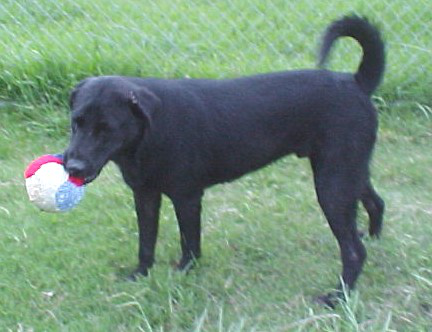

In [ ]:
img = getRandomImage()

score, prediction = predict_cat_or_dog(img)

print(prediction)
print(score)
display(img)